**Table of contents**<a id='toc0_'></a>    
- [AI Tools Declaration](#toc1_)    
- [Prediction Metrics](#toc2_)    
- [Question 1](#toc3_)    
  - [Dataset Overview](#toc3_1_)    
  - [Visual Data Exploration](#toc3_2_)    
  - [Choosing the Right Metric](#toc3_3_)    
  - [Benchmarking a Random Classifier](#toc3_4_)    
  - [Understanding AUC Metrics for Random Classifier](#toc3_5_)    
- [Question 2](#toc4_)    
  - [Metrics](#toc4_1_)    
  - [AUC](#toc4_2_)    
- [Question 3](#toc5_)    
  - [SVM](#toc5_1_)    
    - [Linear](#toc5_1_1_)    
    - [Polynomial kernel](#toc5_1_2_)    
    - [RBF kernel](#toc5_1_3_)    
    - [Random forest](#toc5_1_4_)    
  - [Comparison](#toc5_2_)    
- [Question 4](#toc6_)    
  - [Training set PCA](#toc6_1_)    
  - [Both sets PCA](#toc6_2_)    
  - [Scree Graph](#toc6_3_)    
  - [Classification with PCA](#toc6_4_)    
    - [Inspection of PCs](#toc6_4_1_)    
    - [Polynomial kernel](#toc6_4_2_)    
    - [RBF kernel](#toc6_4_3_)    
- [Question 5](#toc7_)    
- [Question 6](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[AI Tools Declaration](#toc0_)

No Generative AI Tools (GAITs) were used in the completion of this coursework. 

In [27]:
import numpy as np
import pandas as pd # for easier tables
import scipy # for image rotation 
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, \
                            average_precision_score, balanced_accuracy_score, f1_score, matthews_corrcoef
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline


X_train = np.loadtxt("Xtrain.csv")
Y_train = np.loadtxt("Ytrain.csv")
X_test = np.loadtxt("Xtest.csv")

# <a id='toc2_'></a>[Prediction Metrics](#toc0_)

# <a id='toc3_'></a>[Question 1](#toc0_)

## <a id='toc3_1_'></a>[Dataset Overview](#toc0_)

In [28]:
np.unique_counts(Y_train)

UniqueCountsResult(values=array([-1.,  1.]), counts=array([2386,  614]))

a) Training set: There are 2386 negative examples, 614 positive examples. Test set: Unknown.

b) There is some class imbalance in the training data, with a N:P ratio of about 4:1. This causes some potential issues in designing a machine learning solution. With an overrepresented negative class, a trained model may exhibit high specificity but low precision, i.e. it focuses more on correctly predicting the negative class. There may be a high number of false negative predictions. 

## <a id='toc3_2_'></a>[Visual Data Exploration](#toc0_)

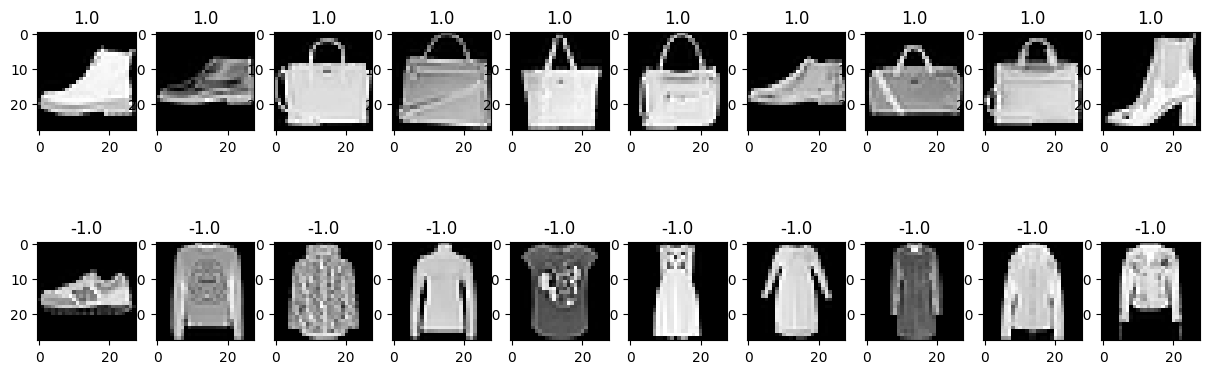

In [29]:
negative_idx = np.asarray(Y_train == -1).nonzero()
positive_idx = np.asarray(Y_train == 1).nonzero()

plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(positive_idx[0], 10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_train[idx])

for i, idx in enumerate(np.random.choice(negative_idx[0], 10)):
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(X_train[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_train[idx])
plt.show()

a) The classes seem to be split by type of clothing. Ankle boots and bags always appear in the class with label 1. Shirts, trainers, trousers and other footwear, tops, and dresses always appear in the class with label -1. This is likely taken from the [Fashion MNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist) dataset, which originally has 10 classes. It appears that the first eight classes have been assigned the label -1, and the other two are assigned the label 1. 

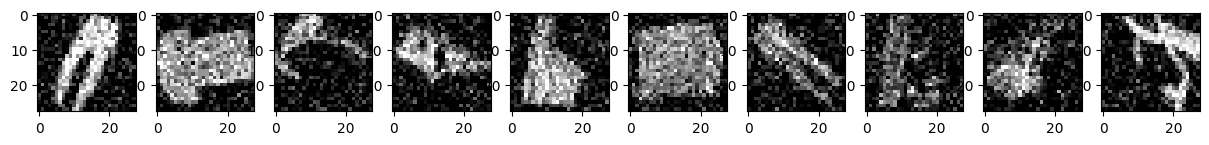

In [30]:
plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_test.shape[0], 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[idx].reshape((28,28)), cmap="gray")
plt.show()


b) The test examples have noise added and are also in a variety of rotations. In order for the classifier to generalise, it must be noise and rotation invariant. 

## <a id='toc3_3_'></a>[Choosing the Right Metric](#toc0_)

Accuracy alone is not a good metric for this task. This is because of the class imbalance. An accuracy of 80% could be achieved in this dataset simply by always predicting the majority class (negative). Despite the high accuracy, this classifier will have zero precision and recall. AUC-ROC suffers from a similar issue where it may not represent imbalanced classes very well. Therefore it makes sense to look at metrics that involve the precision and recall - such as AUC-PR, F1, and Matthews Correlation Coefficient.

## <a id='toc3_4_'></a>[Benchmarking a Random Classifier](#toc0_)
We would expect the accuracy on both the test and training datasets to be 50%. This is because for any given example, the classifier has a 50% chance of predicting the correct class, as there are two classes.

In [31]:
probs = np.random.uniform(-1, 1, X_train.shape[0]) # Random guess for each example 
probs[probs > 0] = 1
probs[probs < 0] = -1
print(f"Number of correct guesses: {(probs==Y_train).sum()} out of {X_train.shape[0]}"
      f" giving {round((probs==Y_train).sum() / X_train.shape[0] * 100, 2)}% accuracy") # Output is always close to 50% 

Number of correct guesses: 1553 out of 3000 giving 51.77% accuracy


The result would be the same for the test set, if we had labels for it. Class imbalance doesn't affect this result. 

## <a id='toc3_5_'></a>[Understanding AUC Metrics for Random Classifier](#toc0_)
The ROC curve for a random classifier would be a line through the diagonal, so the AUC-ROC metric would be about half of the theoretical maximum. 


0.5129207838340373

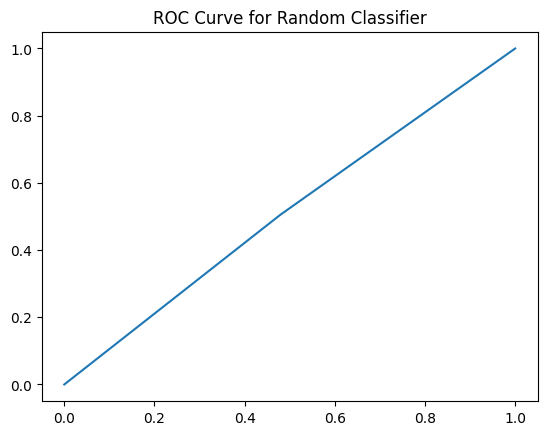

In [32]:
fpr, tpr, thresholds = roc_curve(Y_train, probs)
plt.plot(fpr, tpr)
plt.title("ROC Curve for Random Classifier")
float(roc_auc_score(Y_train, probs)) # ROC AUC score is about 50%, which is the worst possible ROC. 

For the PR curve, at a high threshold, a small number of examples are predicted positive, about a fifth of which actually are positive (as the positive class makes up a fifth of the dataset). At a threshold of -1, all the examples are predicted positive, again about a fifth of these are actually positive. So no matter the threshold, the precision should be around a fifth. To be precise, it should tend to a fifth as the threshold tends to -1. As the threshold decreases, more and more examples are predicted as positive, which means the true positive rate increases. So we expect a vertical line centered at a precision of roughly 0.2.

For PR curves, we don't usually use an AUC metric. Instead we use the average precision. Based on the expected shape of the PR curve we would expect an average precision of 0.2, compared to the theoretical maximum of 1. 

0.2090516113653058

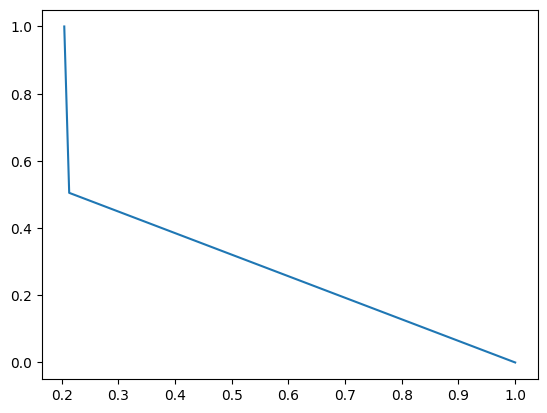

In [37]:
precision, recall, thresholds = precision_recall_curve(Y_train, probs)
plt.plot(precision, recall)
float(average_precision_score(Y_train, probs))


# <a id='toc4_'></a>[Question 2](#toc0_)

## <a id='toc4_1_'></a>[Metrics](#toc0_)

The **accuracy** is given by the number of correctly classified examples divided by the number of examples. Equivalently, 
$$ Acc = \frac{TP + TN}{TP + TN + FP + FN} $$
The **[balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)** is a metric used to deal with imbalanced datasets, defined as the average of recall obtained on each class, where recall is given by $\frac{TP}{TP+FN}$

**AUC-ROC** is the area under the ROC curve. The ROC curve is obtained by plotting the true positive rate (recall) against the false positive rate (given by $\frac{FN}{TP + FN}$) for a set of threshold values.

**AUC-PR** is the area under the PR curve. The PR curve is obtained by plotting the true positive rate (recall) against precision (given by $\frac{TP}{FP+TP}$) for a set of threshold values. 

The **[F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)** is the harmonic mean of the precision and recall, given by $\frac{2 \cdot TP}{2 \cdot TP + FP + FN}$

The **[Matthews correlation coefficient](https://en.wikipedia.org/wiki/Phi_coefficient)** or phi coefficient takes into account all four squares of the confusion matrix. It is given by
$$\frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

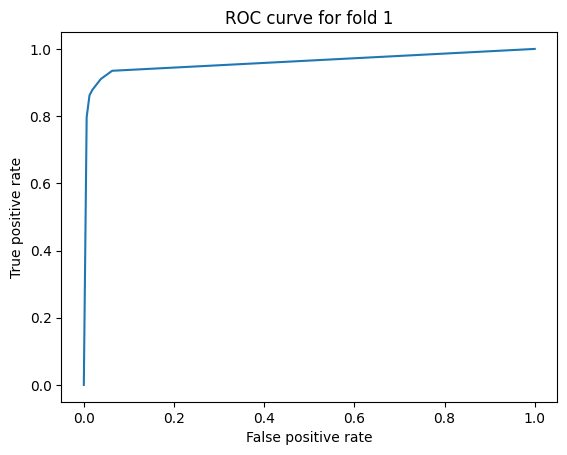

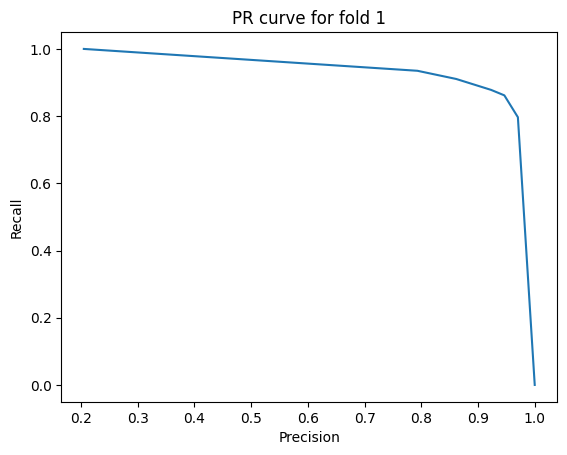

Metric			Mean	Standard Deviation
accuracy		0.965	0.0059
balanced accuracy	0.943	0.009
auc-roc			0.972	0.01
auc-pr			0.935	0.0178
f1-score		0.913	0.0141
matthews		0.891	0.0177


In [38]:


skf = StratifiedKFold(n_splits=5)
knn =  KNeighborsClassifier(5)

accuracies = []
balanced_accuracies = []
auc_rocs = []
auc_prs = []
f1s = []
mccs = []

for i, (train_idx, test_idx) in enumerate(skf.split(X_train, Y_train)):
    Xtr, Ytr = X_train[train_idx], Y_train[train_idx]
    Xval, Yval = X_train[test_idx], Y_train[test_idx]

    knn.fit(Xtr, Ytr)
    Y_pred = knn.predict(Xval)

    accuracy = (Y_pred==Yval).sum() / Yval.shape[0]
    balanced_accuracy = balanced_accuracy_score(Yval,Y_pred)

    # Need to use predict_proba for knn auc 
    y_scores = knn.predict_proba(Xval)
    fpr, tpr, thresholds = roc_curve(Yval, y_scores[:, 1])
    precision, recall, thresholds = precision_recall_curve(Yval, y_scores[:, 1])

    auc_roc = roc_auc_score(Yval, y_scores[:, 1])
    auc_pr = average_precision_score(Yval, y_scores[:, 1])

    f1 = f1_score(Yval, Y_pred)
    mcc = matthews_corrcoef(Yval, Y_pred)

    if i == 1: # plot the roc and pr curves for the first fold
        plt.plot(fpr, tpr)
        plt.title("ROC curve for fold 1")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.show()
        plt.plot(precision, recall)
        plt.title("PR curve for fold 1")
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.show()

    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    auc_rocs.append(auc_roc)
    auc_prs.append(auc_pr)
    f1s.append(f1)
    mccs.append(mcc)

print("Metric\t\t\tMean\tStandard Deviation")
for mname, metric in {'accuracy\t': accuracies, 'balanced accuracy': balanced_accuracies, 
                      'auc-roc\t\t': auc_rocs, 'auc-pr\t\t': auc_prs, 'f1-score\t': f1s, 'matthews\t': mccs}.items():
    mean = np.mean(metric)
    sd = np.std(metric)
    print(f"{mname}\t{round(mean, 3)}\t{round(sd, 4)}")



## <a id='toc4_2_'></a>[AUC](#toc0_)

We notice that the ROC and PR curves both have high areas. For the ROC, we're particularly interested in the top left corner of the graph, where we have both a high true positive rate and a low false positive rate. Note that we can achieve a TPR of over 0.9 while keeping below a 0.1 FPR. This would suggest a strong classifier, but to confirm, we should check the PR curve which can better represent class imbalances. The PR curve staying close to the top-right corner indicates that the classifier has good precision for unbalanced classes. 

# <a id='toc5_'></a>[Question 3](#toc0_)

Classifier options: 
- Linear SVM
- SVM with polynomial kernel
- SVM with RBF kernel
- Random Forest Classifiers
## <a id='toc5_1_'></a>[SVM](#toc0_)
### <a id='toc5_1_1_'></a>[Linear](#toc0_)

In [39]:
svc = SVC()

parameters = {'kernel': ['linear'], 'C': np.linspace(0.1, 1, 10)} # Value of C does not affect the linear SVM
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 
pipeline = make_pipeline(StandardScaler(), clf)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'kernel': ['linear']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [ ]:

#print(clf.best_params_)

# Convert each combination of parameters into strings
param_list = [", ".join(
                [f"{param}: {round(params[param], 3)\
                    if np.isreal(params[param]) \
                    else params[param]}" 
                    for param in params]) 
                for params in clf.cv_results_['params']]

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']
results_list = {key: clf.cv_results_.get(key) for key in keys}

df = pd.DataFrame.from_dict(results_list, orient='index', columns=param_list)
df

,"C: 0.1, degree: 2, kernel: poly","C: 0.1, degree: 3, kernel: poly","C: 0.1, degree: 4, kernel: poly","C: 0.325, degree: 2, kernel: poly","C: 0.325, degree: 3, kernel: poly","C: 0.325, degree: 4, kernel: poly","C: 0.55, degree: 2, kernel: poly","C: 0.55, degree: 3, kernel: poly","C: 0.55, degree: 4, kernel: poly","C: 0.775, degree: 2, kernel: poly","C: 0.775, degree: 3, kernel: poly","C: 0.775, degree: 4, kernel: poly","C: 1.0, degree: 2, kernel: poly","C: 1.0, degree: 3, kernel: poly","C: 1.0, degree: 4, kernel: poly"
mean_test_accuracy,0.932667,0.921667,0.899000,0.954667,0.943000,0.924667,0.960333,0.952000,0.929000,0.964667,0.957333,0.935000,0.966333,0.958667,0.940000
std_test_accuracy,0.005637,0.007601,0.008000,0.004876,0.003055,0.007180,0.005207,0.003559,0.006799,0.005812,0.003432,0.004944,0.005518,0.003055,0.005869
mean_test_balanced_accuracy,0.845786,0.815905,0.756277,0.901971,0.872235,0.824423,0.918843,0.894850,0.838042,0.929445,0.909695,0.852683,0.932907,0.914160,0.866105
std_test_balanced_accuracy,0.013068,0.018101,0.018868,0.010272,0.005853,0.016155,0.011328,0.007753,0.013346,0.013111,0.009529,0.009540,0.011580,0.007375,0.012636
mean_test_roc_auc,0.982248,0.985527,0.982910,0.985661,0.988416,0.985644,0.986141,0.989511,0.986539,0.986824,0.989921,0.987630,0.987032,0.990106,0.988067
std_test_roc_auc,0.006555,0.004378,0.004656,0.006238,0.003932,0.003733,0.006082,0.003940,0.003453,0.005538,0.003737,0.002745,0.005529,0.003674,0.002595
mean_test_average_precision,0.953904,0.956137,0.949143,0.965121,0.965999,0.956701,0.967326,0.969781,0.959743,0.969464,0.971470,0.961543,0.970251,0.972494,0.962777
std_test_average_precision,0.007794,0.008696,0.007498,0.006793,0.006424,0.005508,0.007037,0.005469,0.005000,0.006006,0.004693,0.004447,0.005772,0.004793,0.003925


We notice that C has very little effect on the linear classifier. 

### <a id='toc5_1_2_'></a>[Polynomial kernel](#toc0_)

In [40]:
parameters = {'kernel': ['poly'], 'C': np.linspace(0.1, 1, 5), 'degree': [2, 3, 4, 5]}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 
pipeline = make_pipeline(StandardScaler(), clf)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                          'degree': [2, 3, 4, 5],
                                          'kernel': ['poly']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [98]:
# Get table of parameters
params = [[round(params['C'], 3), params['degree']] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'degree'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]


,C,degree,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
16,1.0,2.0,0.966333,0.005518,0.932907,0.011580,0.987032,0.005529,0.970251,0.005772
16,1.0,2.0,0.966333,0.005518,0.932907,0.011580,0.987032,0.005529,0.970251,0.005772
17,1.0,3.0,0.958667,0.003055,0.914160,0.007375,0.990106,0.003674,0.972494,0.004793
17,1.0,3.0,0.958667,0.003055,0.914160,0.007375,0.990106,0.003674,0.972494,0.004793


Based on the maximum values of the metrics, the best-performing polynomial SVM classifiers use C=1.0 and degree=2 or 3. To choose between them, we will look for the lowest standard deviation. By inspection we can see that degree of 3 has lower standard deviation across all metrics, so we choose C=1.0, degree=3 as our best polynomial SVM classifier. 

### <a id='toc5_1_3_'></a>[RBF kernel](#toc0_)

In [15]:
parameters = {'kernel': ['rbf'], 'C': np.linspace(0.5, 5, 10), 'gamma': np.linspace(0.001, 0.01, 10)}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

pipeline = make_pipeline(StandardScaler(), clf)
pipeline.fit(X_train, Y_train) #warning: takes a few minutes to run 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                                          'gamma': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ]),
                                          'kernel': ['rbf']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [16]:
# Get table of parameters
params = [[round(params['C'], 3), round(params['gamma'], 4)] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'gamma'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]
#df

,C,gamma,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
91,5.0,0.002,0.971333,0.005518,0.957795,0.006169,0.993098,0.003898,0.981864,0.003679
91,5.0,0.002,0.971333,0.005518,0.957795,0.006169,0.993098,0.003898,0.981864,0.003679
61,3.5,0.002,0.970000,0.004714,0.955743,0.004983,0.993183,0.003878,0.981998,0.003814
61,3.5,0.002,0.970000,0.004714,0.955743,0.004983,0.993183,0.003878,0.981998,0.003814


The classifiers with (C=5.0, gamma=0.002) and (C=3.5, gamma=0.002) score the highest in the chosen metrics. The latter achieves a higher average precision, which is an important metric in this problem due to the imbalanced classes, so we'll choose C=3.5 and gamma=0.002 as our RBF SVC classifier. 

### <a id='toc5_1_4_'></a>[Random forest](#toc0_)

In [17]:
rf = RandomForestClassifier()

parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [10, 50, 100, 250]}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(rf, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

pipeline = make_pipeline(StandardScaler(), clf)
pipeline.fit(X_train, Y_train) #warning: takes a few minutes to run 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'max_depth': [10, 20, 30, 40, 50],
                                          'n_estimators': [10, 50, 100, 250]},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [18]:
# Get table of parameters
params = [[params['criterion'], params['max_depth'], params['n_estimators']] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['criterion', 'max_depth', 'n_estimators'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df[keys] = df[keys].astype(float).round(3)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]

#df

,criterion,max_depth,n_estimators,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
19,gini,50,250,0.973,0.006,0.953,0.007,0.992,0.004,0.980,0.005
19,gini,50,250,0.973,0.006,0.953,0.007,0.992,0.004,0.980,0.005
15,gini,40,250,0.969,0.007,0.947,0.010,0.993,0.004,0.979,0.006
7,gini,20,250,0.972,0.007,0.952,0.009,0.992,0.004,0.980,0.006


Criterion gini, max_depth 20, n_estimators 250 scores the highest mean average precision, so we'll choose this classifier for Random Forest. 

## <a id='toc5_2_'></a>[Comparison](#toc0_)

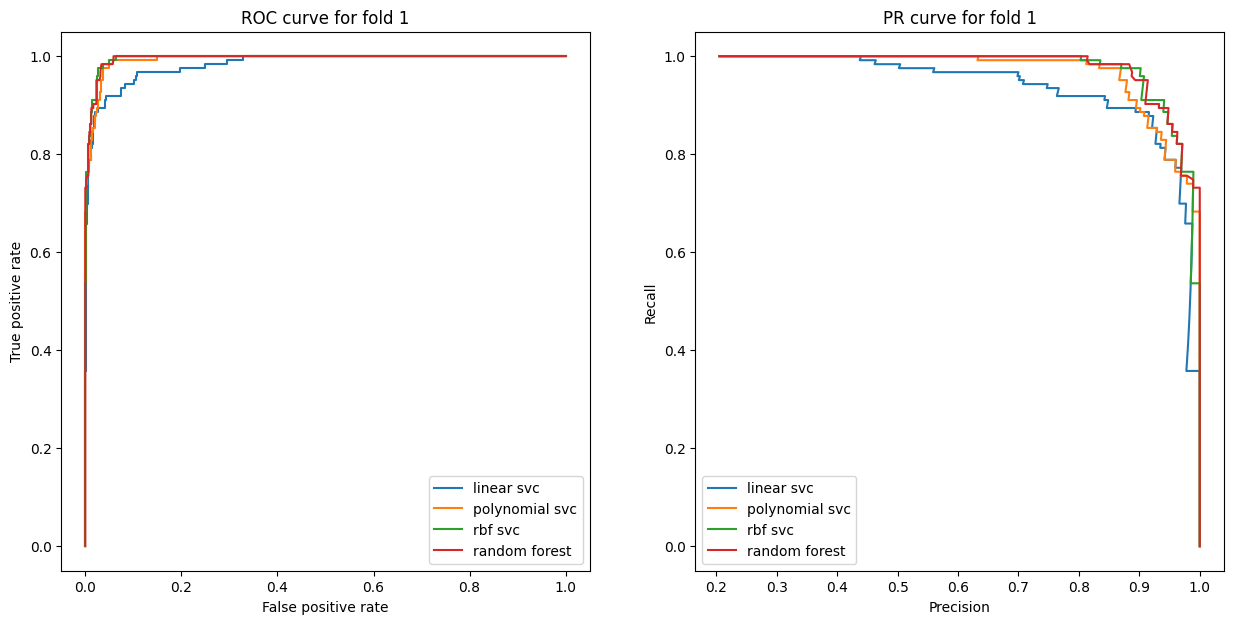

,linear svc,polynomial svc,rbf svc,random forest
accuracy,0.946333,0.958333,0.970333,0.972667
balanced_accuracy,0.921494,0.913951,0.955952,0.951390
auc_roc,0.980322,0.988521,0.993123,0.992519
auc_pr,0.935382,0.971076,0.981713,0.979986


In [ ]:
skf = StratifiedKFold(n_splits=5)
svc_linear = SVC(kernel='linear', probability=True)
svc_poly = SVC(kernel='poly', C=1.0, degree=3, probability=True)
svc_rbf = SVC(kernel='rbf', C=3.5, gamma=0.002, probability=True)
rf = RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=250)

classifiers = {svc_linear: 'linear svc', svc_poly: 'polynomial svc', svc_rbf: 'rbf svc', rf: 'random forest'}

metrics = {model: {'accuracy': 0, 'balanced_accuracy': 0, 'auc_roc': 0, 'auc_pr': 0} for model in classifiers.values()}

accuracies = []
balanced_accuracies = []
auc_rocs = []
auc_prs = []

plt.figure(figsize=[15, 7])

for i, (train_idx, test_idx) in enumerate(skf.split(X_train, Y_train)):
    Xtr, Ytr = X_train[train_idx], Y_train[train_idx]
    Xval, Yval = X_train[test_idx], Y_train[test_idx]

    scaler = StandardScaler()
    scaler.fit(Xtr)
    Xtr = scaler.transform(Xtr)
    Xval = scaler.transform(Xval)

    for model, modelname in classifiers.items():
        model.fit(Xtr, Ytr)
        Y_pred = model.predict(Xval)
        accuracy = (Y_pred==Yval).sum() / Yval.shape[0]
        balanced_accuracy = balanced_accuracy_score(Yval,Y_pred)
        Y_scores = model.predict_proba(Xval)
        fpr, tpr, thresholds = roc_curve(Yval, Y_scores[:, 1])
        precision, recall, thresholds = precision_recall_curve(Yval, Y_scores[:, 1])

        auc_roc = roc_auc_score(Yval, Y_scores[:, 1])
        auc_pr = average_precision_score(Yval, Y_scores[:, 1])

        metrics[modelname]['accuracy'] += accuracy / 5
        metrics[modelname]['balanced_accuracy'] += balanced_accuracy / 5
        metrics[modelname]['auc_roc'] += auc_roc / 5
        metrics[modelname]['auc_pr'] += auc_pr / 5

        if i == 1: # plot the roc and pr curves for the first fold
            plt.subplot(1, 2, 1)
            plt.plot(fpr, tpr, label=modelname)
            plt.title("ROC curve for fold 1")
            plt.xlabel("False positive rate")
            plt.ylabel("True positive rate")
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(precision, recall, label=modelname)
            plt.title("PR curve for fold 1")
            plt.xlabel("Precision")
            plt.ylabel("Recall")
            plt.legend()

    if i == 1:        
        plt.show()

df = pd.DataFrame.from_dict(metrics)
df


Notice that polynomial SVC, RBF SVC, and Random Forest all have similar ROC and PR curves, all performing very well (with the curves going close to the corner). Linear SVC performs the worst, with AUC-PR of 0.93, compared to 0.97-0.98 for the other classifiers. Also notice that in the PR curve, the recall for the linear SVC drops off much earlier than for the other classifiers. This suggests that the Linear SVC model is least able to deal with the class imbalance in the dataset. 

# <a id='toc6_'></a>[Question 4](#toc0_)

## <a id='toc6_1_'></a>[Training set PCA](#toc0_)

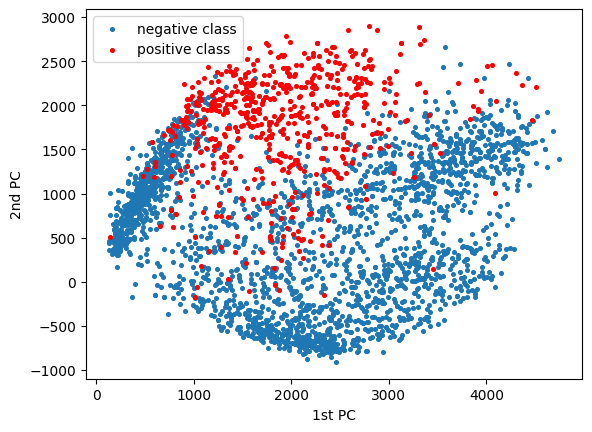

In [ ]:

pca = PCA(n_components=2)
pca.fit(X_train)

negative_idx = np.asarray(Y_train == -1).nonzero()
positive_idx = np.asarray(Y_train == 1).nonzero()

Z_train_negative =  np.inner(pca.components_, X_train[negative_idx]).T
Z_train_positive = np.inner(pca.components_, X_train[positive_idx]).T

plt.scatter(Z_train_negative[:,0], Z_train_negative[:,1], s=7, label='negative class')
plt.scatter(Z_train_positive[:,0], Z_train_positive[:,1], s=7, label='positive class', color='red')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.legend()


We can see that the two classes do appear to follow different distributions, with the positive class generally having a larger transformed value for the 2nd principal component. Also, it's interesting to note in the negative class that there are several areas that clearly have a higher density of examples. These likely represent "subclasses" within the negative class, for example, shirts, dresses, or jackets. 
## <a id='toc6_2_'></a>[Both sets PCA](#toc0_)

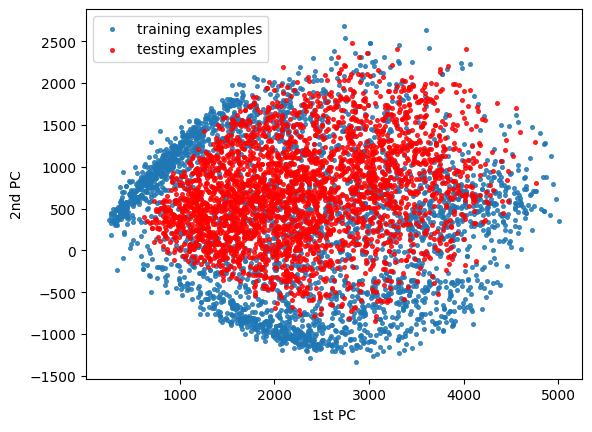

In [4]:
X_all = np.vstack([X_train, X_test])

pca2 = PCA(n_components=2)
pca2.fit(X_all)

negative_idx = np.asarray(Y_train == -1).nonzero()
positive_idx = np.asarray(Y_train == 1).nonzero()

Z_train =  np.inner(pca2.components_, X_train).T
Z_test = np.inner(pca2.components_, X_test).T

plt.scatter(Z_train[:,0], Z_train[:,1], s=7, label='training examples', alpha=0.8)
plt.scatter(Z_test[:,0], Z_test[:,1], s=7, label='testing examples', color='red', alpha=0.8)
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.legend()

This graph makes it clear that the testing examples do follow a different distribution to the training examples. The testing examples do not feature the same denser areas that the training examples do, instead being more uniformly spread amongst the graph, which is likely because of the noise and rotational variance in the testing examples. We can also observe that the distribution of training examples appears very similar to the distribution of training examples in the first graph, suggesting that in both cases PCA found very similar principal components. Finally, notice that the testing examples generally have less extreme transformed values, with the distribution being packed more closely to the centre. Again, this is most likely caused by the noise in the images, which causes the principal components to explain less of the variance in the images. 

## <a id='toc6_3_'></a>[Scree Graph](#toc0_)

218


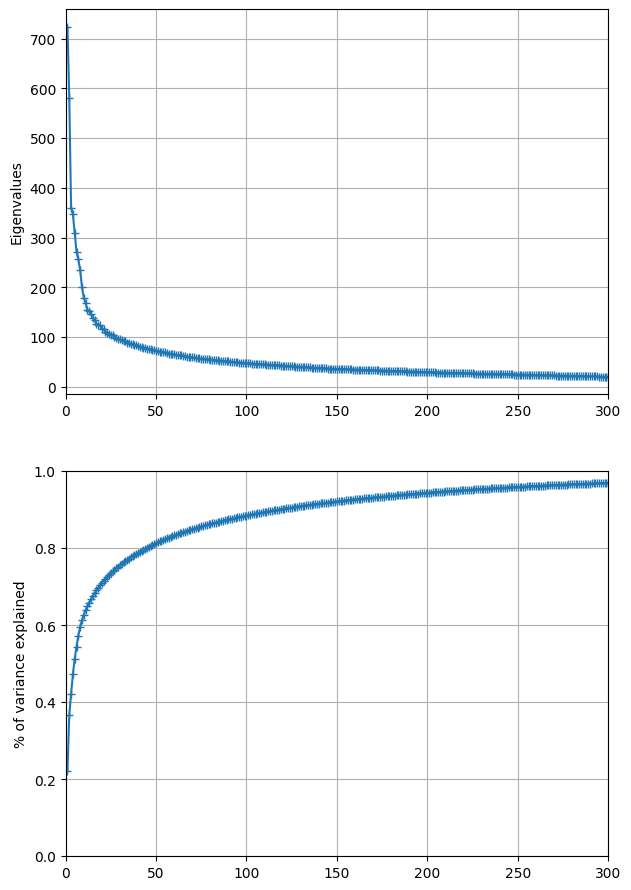

In [29]:
num_components = 300

pca = PCA(n_components=num_components)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
pca.fit(X_train_s)



plt.figure(figsize=[7, 11])

plt.subplot(2, 1, 1)
plt.plot(np.arange(1, num_components+1), pca.singular_values_[:num_components], marker='+')
plt.ylabel('Eigenvalues')
plt.xlim(0, num_components)
plt.grid()

plt.subplot(2, 1, 2)
y = np.cumsum(pca.explained_variance_ratio_[:num_components])
plt.plot(np.arange(1, num_components+1), y, marker='+')
plt.ylabel('% of variance explained')
plt.ylim([0, 1])
plt.xlim(0, num_components)
plt.grid()

print(np.searchsorted(y, 0.95) + 1) # Number of PCs needed to explain 95% of the variance


## <a id='toc6_4_'></a>[Classification with PCA](#toc0_)

### <a id='toc6_4_1_'></a>[Inspection of PCs](#toc0_)

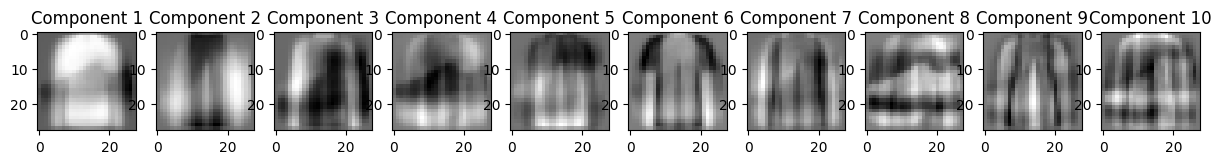

In [ ]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pca.components_[i].reshape((28,28)), cmap="gray")
    plt.title(f"Component {i+1}")



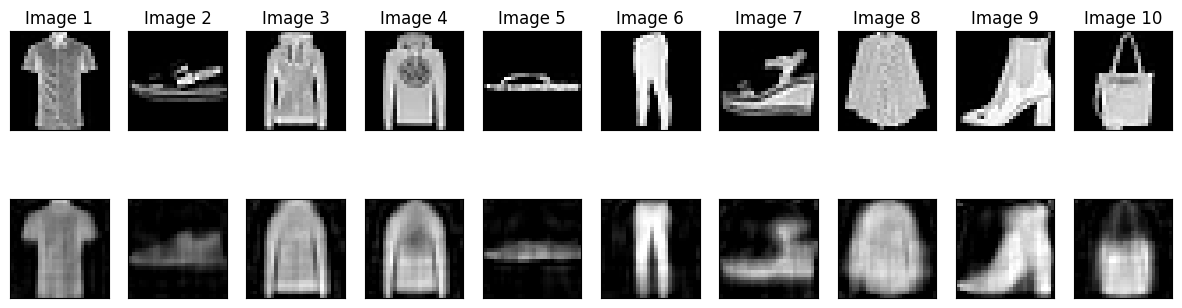

In [124]:
num_components = 50

plt.figure(figsize=(15,4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Image {i+1}")
    plt.subplot(2, 10, 10+i+1)
    plt.xticks([])
    plt.yticks([])
    Z_example = np.inner(pca.components_[:num_components], X_train[i]).T
    plt.imshow(np.inner(pca.components_[:num_components].T, Z_example).T.reshape(28, 28), cmap='gray', vmin=0, vmax=255)


### <a id='toc6_4_2_'></a>[Polynomial kernel](#toc0_)

In [138]:
parameters = {'kernel': ['poly'], 'C': np.logspace(-3, 3, 7), 'degree': range(2, 10)}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 

num_components = 25

# We want to perform scaling and PCA in the pipeline so as to avoid data leakage during cross-validation
pipeline = make_pipeline(StandardScaler(), PCA(n_components=75), clf)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                          'degree': range(2, 10),
                                          'kernel': ['poly']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [139]:
# Get table of parameters
params = [[round(params['C'], 3), params['degree']] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'degree'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]

,C,degree,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
33,10.0,3.0,0.970000,0.004216,0.945470,0.006209,0.989519,0.004705,0.974016,0.008139
41,100.0,3.0,0.966667,0.004714,0.946404,0.007227,0.986966,0.004341,0.965907,0.009003
25,1.0,3.0,0.961667,0.002108,0.921485,0.004491,0.990059,0.004092,0.973247,0.006192
33,10.0,3.0,0.970000,0.004216,0.945470,0.006209,0.989519,0.004705,0.974016,0.008139


best so far: C = 1.0, degree = 3, num_components = 100

### <a id='toc6_4_3_'></a>[RBF kernel](#toc0_)

In [5]:
parameters = {'kernel': ['rbf'], 'C': np.logspace(-1, 2, 10), 'gamma': np.logspace(-4, -1, 10)}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 

num_components = 75

# We want to perform scaling and PCA in the pipeline so as to avoid data leakage during cross-validation
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), clf)
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                                          'gamma': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ]),
                                          'kernel': ['rbf']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [6]:
params = [[round(params['C'], 3), round(params['gamma'], 4)] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'gamma'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]

,C,gamma,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
64,10.000,0.0022,0.974667,0.004000,0.961096,0.004327,0.993311,0.003957,0.982368,0.005343
55,4.642,0.0046,0.972667,0.005333,0.961657,0.005681,0.992990,0.003876,0.980374,0.007260
54,4.642,0.0022,0.973333,0.002357,0.957234,0.005690,0.993696,0.003887,0.983382,0.004034
54,4.642,0.0022,0.973333,0.002357,0.957234,0.005690,0.993696,0.003887,0.983382,0.004034


The best classifier appears to be RBF SVM with C = 4.642 and gamma = 0.0022, with 25 PCA components

# <a id='toc7_'></a>[Question 5](#toc0_)

The first thing we're going to do is artifically add noise and rotation to our training data. We'll also make copies of the images, so that each image can have several different rotations. 

(15000, 784)


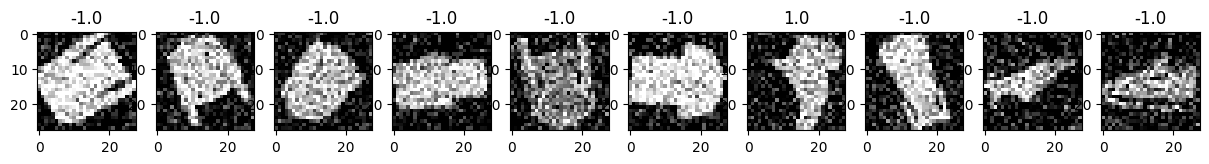

In [5]:
X_train_t = np.tile(X_train, (5, 1))
Y_train_t = np.tile(Y_train, 5)
print(X_train_t.shape)

# Rotate each image
X_train_r = X_train_t.reshape([-1, 28, 28])
for i in range(X_train_r.shape[0]):
    X_train_r[i] = scipy.ndimage.rotate(X_train_r[i], axes=(0,1), angle=np.random.uniform(-180, 180), reshape=False)
X_train_r = X_train_r.reshape([-1, 28 * 28])

# Add noise
X_train_n = X_train_r + np.random.normal(0, 60, size = X_train_r.shape)
X_train_n = np.clip(X_train_n, 0, 255) # Clamp values back to the range (0, 255)

plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train_n[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_train[idx])

Now we'll try to make some predictions as before:

In [78]:
svc = SVC(kernel='rbf', C=4.642, gamma=0.0022, probability=True)
num_components = 75
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), svc)
pipeline.fit(X_train_n, Y_train_t)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('svc', SVC(C=4.642, gamma=0.0022, probability=True))])

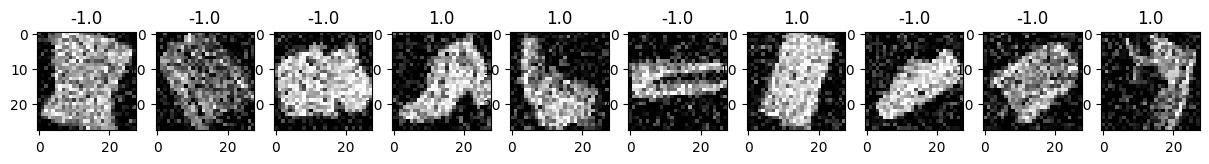

UniqueCountsResult(values=array([-1.,  1.]), counts=array([2520,  480]))


In [80]:
Y_pred = pipeline.predict(X_test)

plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_test.shape[0], 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[idx].reshape((28,28)), cmap="gray")
    plt.title(Y_pred[idx])
plt.show()
print(np.unique_counts(Y_pred))

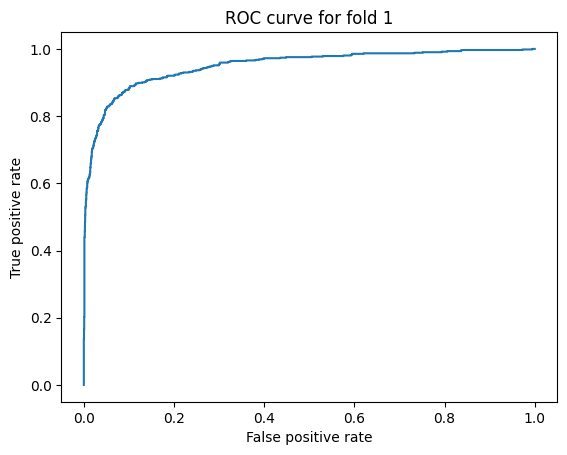

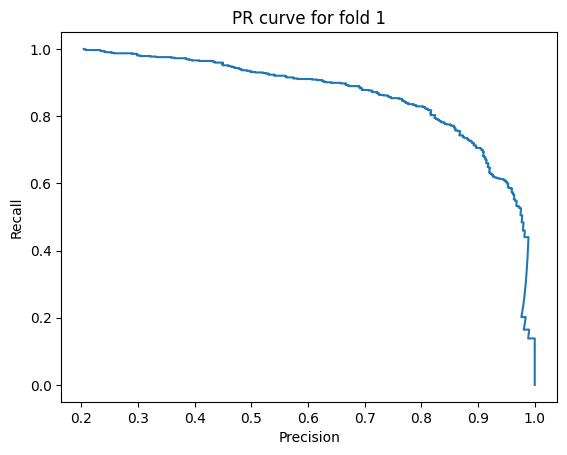

Metric			Mean	Standard Deviation
accuracy		0.926	0.0025
balanced accuracy	0.853	0.0045
auc-roc			0.952	0.0013
auc-pr			0.891	0.0044


In [81]:
skf = StratifiedKFold(n_splits=5)

accuracies = []
balanced_accuracies = []
auc_rocs = []
auc_prs = []

for i, (train_idx, test_idx) in enumerate(skf.split(X_train_n, Y_train_t)):
    Xtr, Ytr = X_train_n[train_idx], Y_train_t[train_idx]
    Xval, Yval = X_train_n[test_idx], Y_train_t[test_idx]

    pipeline.fit(Xtr, Ytr)
    Y_pred = pipeline.predict(Xval)

    accuracy = (Y_pred==Yval).sum() / Yval.shape[0]
    balanced_accuracy = balanced_accuracy_score(Yval,Y_pred)

    # Need to use predict_proba for knn auc 
    y_scores = pipeline.predict_proba(Xval)
    fpr, tpr, thresholds = roc_curve(Yval, y_scores[:, 1])
    precision, recall, thresholds = precision_recall_curve(Yval, y_scores[:, 1])

    auc_roc = roc_auc_score(Yval, y_scores[:, 1])
    auc_pr = average_precision_score(Yval, y_scores[:, 1])

    if i == 1: # plot the roc and pr curves for the first fold
        plt.plot(fpr, tpr)
        plt.title("ROC curve for fold 1")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.show()
        plt.plot(precision, recall)
        plt.title("PR curve for fold 1")
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.show()

    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    auc_rocs.append(auc_roc)
    auc_prs.append(auc_pr)

print("Metric\t\t\tMean\tStandard Deviation")
for mname, metric in {'accuracy\t': accuracies, 'balanced accuracy': balanced_accuracies, 
                      'auc-roc\t\t': auc_rocs, 'auc-pr\t\t': auc_prs}.items():
    mean = np.mean(metric)
    sd = np.std(metric)
    print(f"{mname}\t{round(mean, 3)}\t{round(sd, 4)}")


Let's find parameters for RBF kernel 

In [83]:
parameters = {'kernel': ['rbf'], 'C': np.logspace(-1, 2, 5), 'gamma': np.logspace(-4, -1, 5)}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 

num_components = 75

# We want to perform scaling and PCA in the pipeline so as to avoid data leakage during cross-validation
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), clf)
pipeline.fit(X_train_n, Y_train_t)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([  0.1       ,   0.56234133,   3.16227766,  17.7827941 ,
       100.        ]),
                                          'gamma': array([0.0001    , 0.00056234, 0.00316228, 0.01778279, 0.1       ]),
                                          'kernel': ['rbf']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [84]:
params = [[round(params['C'], 3), round(params['gamma'], 4)] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'gamma'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]

,C,gamma,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
12,3.162,0.0032,0.929000,0.002357,0.856544,0.002647,0.956526,0.001503,0.897701,0.004306
22,100.000,0.0032,0.928133,0.002655,0.868942,0.005962,0.957373,0.001961,0.894136,0.006336
17,17.783,0.0032,0.927933,0.002776,0.868574,0.005851,0.957622,0.001989,0.894607,0.006306
12,3.162,0.0032,0.929000,0.002357,0.856544,0.002647,0.956526,0.001503,0.897701,0.004306


Let's find parameters for random forest

In [85]:
rf = RandomForestClassifier()

parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [10, 50, 100, 250]}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
clf = GridSearchCV(rf, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

num_components = 75

# We want to perform scaling and PCA in the pipeline so as to avoid data leakage during cross-validation
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), clf)
pipeline.fit(X_train_n, Y_train_t)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'max_depth': [10, 20, 30, 40, 50],
                                          'n_estimators': [10, 50, 100, 250]},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [86]:
# Get table of parameters
params = [[params['criterion'], params['max_depth'], params['n_estimators']] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['criterion', 'max_depth', 'n_estimators'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df[keys] = df[keys].astype(float).round(3)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]

,criterion,max_depth,n_estimators,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
11,gini,30,250,0.913,0.002,0.808,0.003,0.929,0.004,0.847,0.005
11,gini,30,250,0.913,0.002,0.808,0.003,0.929,0.004,0.847,0.005
55,log_loss,40,250,0.911,0.001,0.801,0.003,0.940,0.004,0.857,0.004
31,entropy,30,250,0.910,0.001,0.801,0.002,0.939,0.003,0.857,0.002


The best performing classifier was the SVM with RBF kernel, C=3.162 and gamma=0.0032, so we'll create this classifier and create our predictions. 

In [6]:
svc = SVC(kernel='rbf', C=3.162, gamma=0.0032, probability=True)
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), svc)

pipeline.fit(X_train_n, Y_train_t)

preds = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)

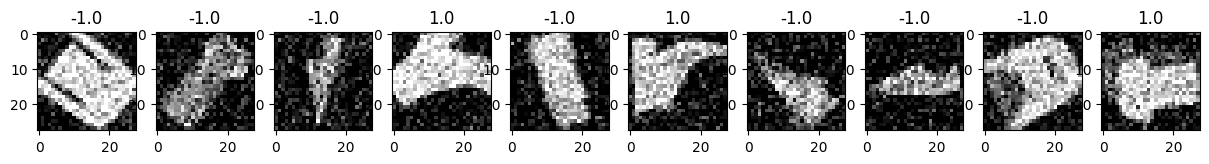

UniqueCountsResult(values=array([-1.,  1.]), counts=array([2480,  520]))


In [8]:
plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_test.shape[0], 10)):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[idx].reshape((28,28)), cmap="gray")
    plt.title(preds[idx])
plt.show()
print(np.unique_counts(preds))

By visual inspection, the classifier appears to be spotting boots and bags quite well. The distribution of predictions is about 83% to 17%, which is similar to the class proportions of 80% to 20% in the training dataset - although this is irrelevant if the distribution of the test data is different, which we don't know. 
Finally, we'll save these predictions to our predictions file.

In [10]:
np.savetxt("u2101693.csv", probs[:,1])

# <a id='toc8_'></a>[Question 6](#toc0_)

In [125]:
new_X_train = np.vstack((X_train, X_test))
new_Y_train_neg = -1 * np.ones(shape=X_train.shape[0])
new_Y_train_pos = np.ones(shape=X_test.shape[0])
new_Y_train = np.concat((new_Y_train_neg, new_Y_train_pos))

print(new_X_train[1,130:180])
print(new_X_train.shape)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
(6000, 784)


In [119]:
parameters = {'kernel': ['rbf'], 'C': np.logspace(-1, 2, 10), 'gamma': np.logspace(-4, -1, 10)}
scoring = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=StratifiedKFold(n_splits=5), refit=False, scoring=scoring)

# We can use a pipeline to carry out scaling at each fold. This is better than carrying out scaling 
# on the entire dataset first, as that would mean the validation data influences the training data. 

num_components = 75

# We want to perform scaling and PCA in the pipeline so as to avoid data leakage during cross-validation
pipeline = make_pipeline(StandardScaler(), PCA(n_components=num_components), clf)
pipeline.fit(new_X_train, new_Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=75)),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(),
                              param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                                          'gamma': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ]),
                                          'kernel': ['rbf']},
                              refit=False,
                              scoring=['accuracy', 'balanced_accuracy',
                                       'roc_auc', 'average_precision']))])

In [126]:
params = [[round(params['C'], 3), round(params['gamma'], 4)] for params in clf.cv_results_['params']] 

keys = ['mean_test_accuracy', 'std_test_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 
        'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_average_precision', 'std_test_average_precision']

# Get table of results
results = np.array([clf.cv_results_.get(key) for key in keys])

# Format the metrics for the table and create columns
keys = [key.replace('test_', '').replace('_', ' ') for key in keys]
columns = ['C', 'gamma'] + keys

# Create the final table and dataframe
table = np.hstack([params, results.T])
df = pd.DataFrame(table, columns=columns)
df.iloc[df[['mean accuracy', 'mean balanced accuracy', 'mean roc auc', 'mean average precision']].idxmax()]
#df

,C,gamma,mean accuracy,std accuracy,mean balanced accuracy,std balanced accuracy,mean roc auc,std roc auc,mean average precision,std average precision
63,10.000,0.001,0.999167,0.000913,0.999167,0.000913,0.999996,0.000006,0.999996,0.000006
63,10.000,0.001,0.999167,0.000913,0.999167,0.000913,0.999996,0.000006,0.999996,0.000006
53,4.642,0.001,0.999000,0.000972,0.999000,0.000972,0.999996,0.000006,0.999996,0.000006
53,4.642,0.001,0.999000,0.000972,0.999000,0.000972,0.999996,0.000006,0.999996,0.000006


The validation accuracy is extremely high across the board. The roc-auc is essentially 1. This indicates that the training and test sets are highly distinguishable. Visualising the test set in Q1 supports this; heavy noise and rotation have been added. To eliminate systematic differences between training and test sets, we can try modifying our training sets to make them more like the test data. We can tell when we've been successful by applying a classifier that was previously able to distingush between the two sets and seeing if it is still able to. 

So we'll use C=10 and gamma = 0.001 with RBF SVC kernel. Let's see how adding noise and rotations affects this result. 

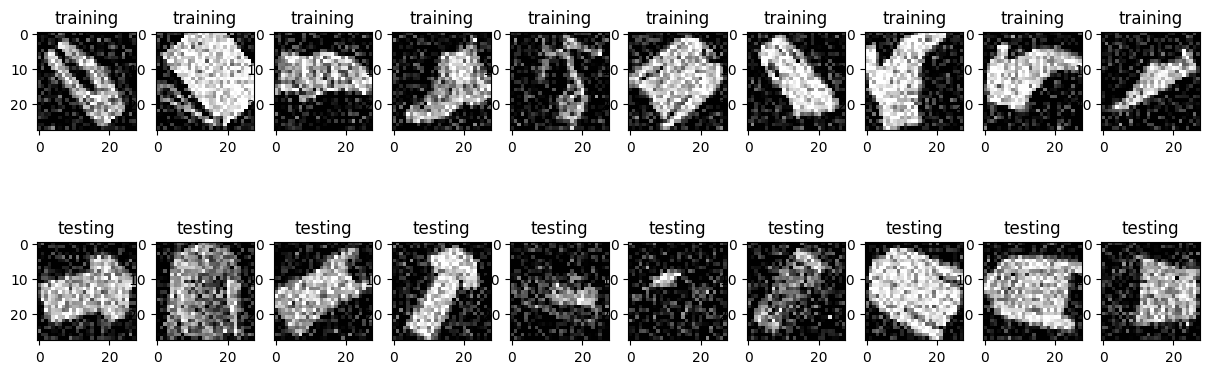

UniqueCountsResult(values=array([-1.,  1.]), counts=array([3000, 3000]))


In [22]:
X_train = np.loadtxt("Xtrain.csv")
Y_train = np.loadtxt("Ytrain.csv")
X_test = np.loadtxt("Xtest.csv")

# Rotate each image
X_train_r = X_train.reshape([-1, 28, 28])
for i in range(X_train_r.shape[0]):
    im_rotated = scipy.ndimage.rotate(X_train_r[i], axes=(0,1), angle=np.random.uniform(-180, 180), reshape=False)
    X_train_r[i] = im_rotated#resize(im_rotated, (28, 28), anti_aliasing=True)
X_train_r = X_train_r.reshape([-1, 28 * 28])

# Add noise
X_train_n = X_train_r + np.random.normal(0, 50, size = X_train_r.shape)
X_train_n = np.clip(X_train_n, 0, 255) # Clamp values back to the range (0, 255)

new_X_train = np.vstack((X_train_n, X_test))
new_Y_train_neg = -1 * np.ones(shape=X_train_n.shape[0])
new_Y_train_pos = np.ones(shape=X_test.shape[0])
new_Y_train = np.concat((new_Y_train_neg, new_Y_train_pos))

plt.figure(figsize=(15,5))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(new_X_train[idx].reshape((28,28)), cmap="gray", vmin=0, vmax=255)
    plt.title("training")
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(X_test[idx].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
    plt.title("testing")
plt.show()
print(np.unique_counts(new_Y_train))

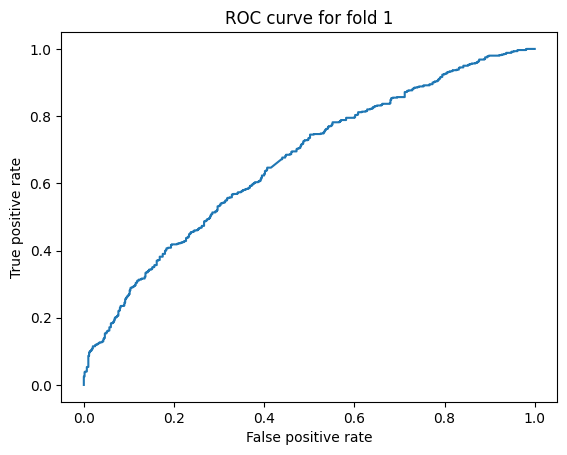

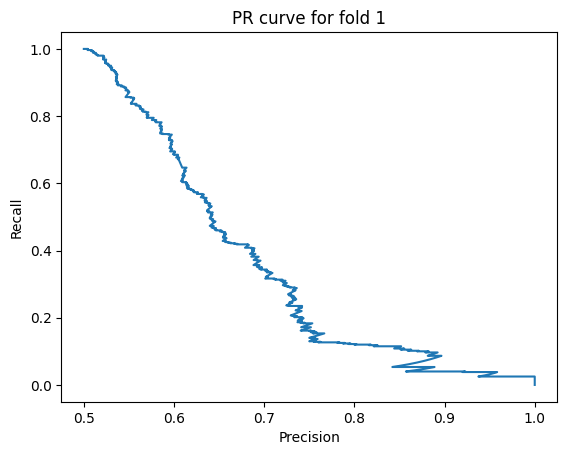

Metric			Mean	Standard Deviation
accuracy		0.635	0.0131
balanced accuracy	0.635	0.0131
auc-roc			0.687	0.0134
auc-pr			0.681	0.0126


In [24]:
skf = StratifiedKFold(n_splits=5)
svc = SVC(kernel='rbf', C=10, gamma=0.001, probability=True)

num_components=75

pipeline = make_pipeline(StandardScaler(), PCA(num_components), svc)

accuracies = []
balanced_accuracies = []
auc_rocs = []
auc_prs = []

for i, (train_idx, test_idx) in enumerate(skf.split(new_X_train, new_Y_train)):
    Xtr, Ytr = new_X_train[train_idx], new_Y_train[train_idx]
    Xval, Yval = new_X_train[test_idx], new_Y_train[test_idx]

    pipeline.fit(Xtr, Ytr)
    Y_pred = pipeline.predict(Xval)

    accuracy = (Y_pred==Yval).sum() / Yval.shape[0]
    balanced_accuracy = balanced_accuracy_score(Yval,Y_pred)

    # Need to use predict_proba for knn auc 
    y_scores = pipeline.predict_proba(Xval)
    fpr, tpr, thresholds = roc_curve(Yval, y_scores[:, 1])
    precision, recall, thresholds = precision_recall_curve(Yval, y_scores[:, 1])

    auc_roc = roc_auc_score(Yval, y_scores[:, 1])
    auc_pr = average_precision_score(Yval, y_scores[:, 1])

    if i == 1: # plot the roc and pr curves for the first fold
        plt.plot(fpr, tpr)
        plt.title("ROC curve for fold 1")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.show()
        plt.plot(precision, recall)
        plt.title("PR curve for fold 1")
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.show()

    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    auc_rocs.append(auc_roc)
    auc_prs.append(auc_pr)

print("Metric\t\t\tMean\tStandard Deviation")
for mname, metric in {'accuracy\t': accuracies, 'balanced accuracy': balanced_accuracies, 
                      'auc-roc\t\t': auc_rocs, 'auc-pr\t\t': auc_prs}.items():
    mean = np.mean(metric)
    sd = np.std(metric)
    print(f"{mname}\t{round(mean, 3)}\t{round(sd, 4)}")

It is clear that the performance of our classifier has significantly dropped, to the point where it is almost completely unable to distinguish between the training and test data. The auc-roc has dropped from almost 1 to 0.687, indicating that the training dataset now much more closely resembles the training dataset. This augmented training data can now be used to train a model which is better able to generalise to the test data. 